# Bayesian Networks

###  Learning the topology from a database of cases using the K2 algorithm

###### L. Belli and S. Di Lucia

###### Padua, 30/06/2025

### Implementing K2

In [ ]:
## Necessary package import
library(bnlearn) |> suppressPackageStartupMessages() 
library(Rgraphviz) |> suppressPackageStartupMessages() 
library(tidyverse) |> suppressPackageStartupMessages() 
library(gtools) |> suppressPackageStartupMessages() 
library(bnstruct) |>suppressPackageStartupMessages()

In [ ]:
# Two helper functions, to ease the dealing with datasets

factor_remover <- function(dataset) {
    cols <- colnames(dataset)
    for (i in seq_along(cols)) {
        name <- cols[i]
        dataset[[name]] <- as.character(dataset[[name]])
    }
    return(dataset)
}


dataset <- function(dataset) {
    if (class(dataset) == 'data.frame') {
        return(factor_remover(dataset))
    } else if (class(dataset) == 'BNDataset') {
        df <- as.data.frame(raw.data(dataset))
        colnames(df) <- dataset@variables
        return(df)
    }
    else {
        ruiz <- data.frame(x1 = c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0),
                          x2 = c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0),
                          x3 = c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0))
        return(ruiz)
    }
}

In [ ]:
node.values <- function(dataset, parents) {
    # retrieves the unique values of the nodes
    #return a list of vectors, 
    # each vector contains the unique values of the corresponding node
    output <- list()
    for (kk in seq_along(parents)) {
        node <- parents[kk]
        node.vals <- unique(dataset[[node]]) #it was levels()
        output[[kk]] <- node.vals
    }
    return(output)
}
fastalphaijk <- function(i, pii, dataset, nodes.order) {
    # Computes the second product of the f(i, pi_i) 
    #function shown in the pseudocode in Ruiz
    actual_node <- nodes.order[i]
    all.nodes <- c(pii, actual_node)
    subset <- dataset[all.nodes]
    unique.instantiations <- expand.grid(node.values(dataset, all.nodes))
    colnames(unique.instantiations) <- colnames(subset)
    subset.counted <- subset |> group_by(across(everything())) |> summarise(n = n(), .groups="drop")
    checking <-  left_join(unique.instantiations, subset.counted, by=colnames(subset), na_matches="na")  |> arrange(across(-last_col()))
    checking$n[is.na(checking$n)]<- 0
    return(checking$n)
}
k2helper <- function(i, pii, dataset, nodes.order, log=TRUE) {
    # the "f(i, pi_i)" function in the Ruiz paper
    #notation follows Ruiz.
    phi_i <- expand.grid(node.values(dataset, pii)) 
    q_i <- dim(phi_i)[1]
    i.th.node <- nodes.order[i]
    v_i <- node.values(dataset, i.th.node)
    r_i <- length(v_i[[1]])
    individual_alphas <- fastalphaijk(i, pii, dataset, nodes.order) 
    grouping_alphas <- matrix(individual_alphas, nrow=r_i) # to get the right Nijs
    nij <- colSums(grouping_alphas)
    # here we compute everything 2 times, once for log-form, once for standard form.
    # not the most efficient thing in the world but the wise says:
    # "if it works, don't touch it"
    produttoria_alpha <- prod(lfactorial(individual_alphas))
    log_produttoria_alpha <- sum(lfactorial(individual_alphas))
    log_numeratore <- sum(lfactorial(rep(r_i-1,q_i))) # r_i - 1 + 1 = r_i
    numeratore <- factorial(r_i-1)
    log_denominatore <- sum(lfactorial(nij + r_i-1)) # nij + r_i - 1 + 1 = nij + r_i
    denominatore <- factorial(nij+r_i-1)
    log_out <- log_numeratore - log_denominatore + log_produttoria_alpha
    out1 <- prod((numeratore/denominatore))*produttoria_alpha # not log-form
    out2 <- sum(log_out) #log-form
    ifelse(log, out <- out2, out<- out1)
    return(out)
}
k2 <- function(dataset, nodes.order, upperbound) {
    # The actual K2 algorithm implementation
    #notation follows Ruiz.
    start <- Sys.time()

    nodes <- colnames(dataset)
    net.dag <- empty.graph(nodes=nodes) # network DAG (Directed Acyclic Graph)
    edges <- list()
    
    
    for (i in seq_along(nodes.order)) {
        actual_node <- nodes.order[i]
        pii <- c() # pi_i
        p.old <- k2helper(i, pii,dataset, nodes.order)
        proceed <- TRUE
        p.new.container <- c()
        while (proceed && length(pii) <= upperbound) {
            predecessors_idx <- i-1
            predecessors <- nodes.order[0:predecessors_idx]
            piiuz <- setdiff(predecessors, pii) # pi_i U {z}
            if (length(piiuz) > 1) {
                daddy.s.probs <- c()
                for (daddy in seq_along(piiuz)) { # searching for the node that maximizes k2helper
                    p.new <- k2helper(i, c(pii, piiuz[daddy]), dataset, nodes.order)
                    daddy.s.probs <- c(daddy.s.probs, c(p.new))
                }
                p.new <- max(daddy.s.probs)
                eventuale.genitore <-  piiuz[daddy.s.probs == p.new]
            } else {
                p.new <- k2helper(i, piiuz, dataset, nodes.order)
                eventuale.genitore <- piiuz
            }

            if (p.new > p.old) { # Updating probabilities
                p.old <- p.new
                pii <- c(pii, eventuale.genitore)
                p.new.container <- c(p.new.container, p.new)
                net.dag <- set.arc(net.dag, from=eventuale.genitore, to=actual_node)
            } else  {
                proceed <- FALSE
            }
        }
        
        # Store edges: each pii is a parent of actual_node 
        if (length(pii) >= 0) {
            for (iterator in seq_along(pii)) {
                parent <- pii[iterator]
                edges[[length(edges) + 1]] <- c(parent, actual_node)
            }
        }

    }
    # computing the network score.
    net.score <- score(net.dag, dataset |> mutate_all(as_factor) |> as.data.frame()) # network scor
    edge_matrix <- do.call(rbind, edges)
    
    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    
    return(list('edges' = edge_matrix, 
                'dag' = net.dag,
                'score' = net.score))
}

In [ ]:
k24optim <- function(order, dataset, upperbound){
    # Optim w/ sann does not want the actual combination of variables, but 
    # accepts a vector of numbers, so we wrapped k2 in order to making it working with optim
    nodenames <- colnames(dataset)
    actual.order <- nodenames[order(order)]
    res <- k2(dataset=dataset, nodes.order=actual.order, upperbound=upperbound)
    return(-res$score) 
}
brute.optim <- function(dataset, title, maxit=1000, temp=10, tmax=10, bruteforce=FALSE) {
    # This function holds both methods we adopted: Bruteforce and SANN
    start <- Sys.time()
    ncols <- length(colnames(dataset))
    # Bruteforce
    if (bruteforce) {
        best.dag <- list(c())
        best.score <- c()
        best.order <- list(c())
        permutations <- permutations(n = ncols, r = ncols, v = colnames(dataset))
        for (i in 1:nrow(permutations)){
            result <- k2(dataset, permutations[i,],upperbound=2)
            #print(result$dag)
            best.dag[[i]] <- result$dag
            best.score[i] <- result$score
            best.order[[i]] <- permutations[i,]
        }
        idxmax <- which.max(best.score) ## looking for the best value
        graphviz.plot(x=best.dag[[idxmax]],
                    highlight=NULL,
                    layout="dot",
                    shape="circle",
                    fontsize=12,
                    main = paste("Bayesian Network Learned with K2\nDataset:", title),
                    render=TRUE)

        end <- Sys.time()
        execution.time <- difftime(time1 = end, time2 = start, units = "secs")
        cat("\nExecution Time:", execution.time, "s\n")
        return(list('dag'=best.dag[[idxmax]],
                    'order'=best.order[[idxmax]], 
                    "score" = best.score[[idxmax]]))
    } else {
        init.par <- seq(1, ncols)
        sann_controls <- list(
            maxit = maxit,
            temp = temp,
            tmax = tmax
        )
        optim_res <- optim(par=init.par,
                            fn= k24optim,
                            dataset=dataset,
                            upperbound=2,
                            method="SANN",
                            control=sann_controls)

        best.order <- colnames(dataset)[order(optim_res$par)]

        result <- k2(dataset=dataset, nodes.order=best.order,upperbound=2)
        graphviz.plot(x=result$dag,
                    highlight=NULL,
                    layout="dot",
                    shape="circle",
                    fontsize=12,
                    main = paste("Bayesian Network Learned with K2\nDataset:", title),
                    render=TRUE)
        end <- Sys.time()
        execution.time <- difftime(time1 = end, time2 = start, units = "secs")
        cat("\nExecution Time:", execution.time, "s\n")

        return(list("dag"=result$dag, "order"=best.order, "score"= result$score))
    }
}


## Learning Topology with K2

### Ruiz Dataset
##### (Bruteforce)


Execution Time: 0.5396223 s


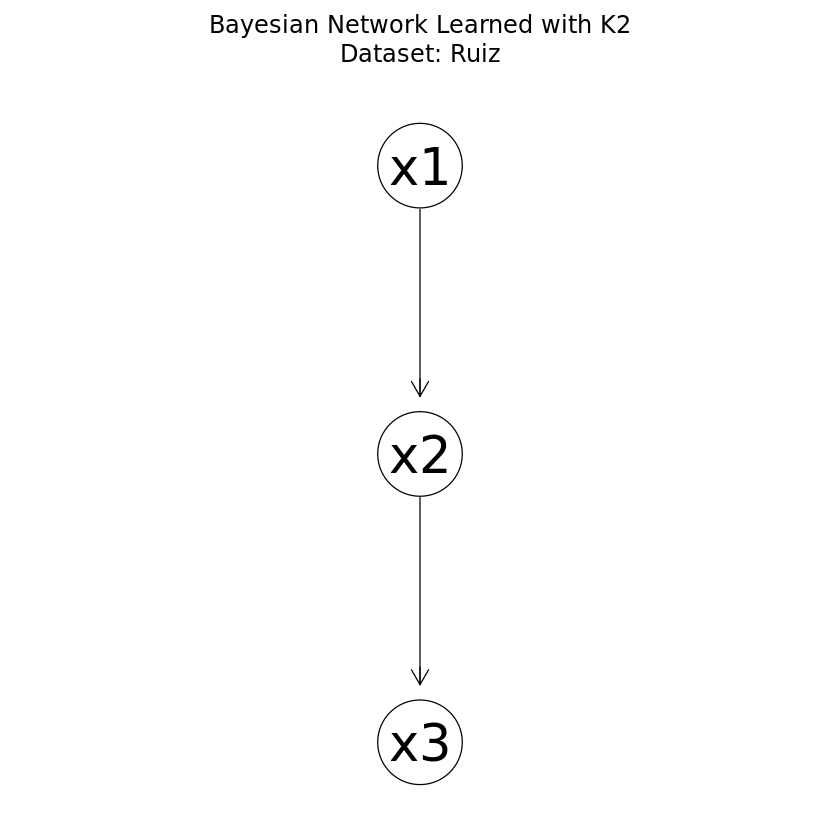

In [ ]:
ruiz.result <- brute.optim(dataset("ruiz"),"Ruiz", bruteforce=TRUE)

### Learning.test

##### (Bruteforce)


Execution Time: 197.336 s


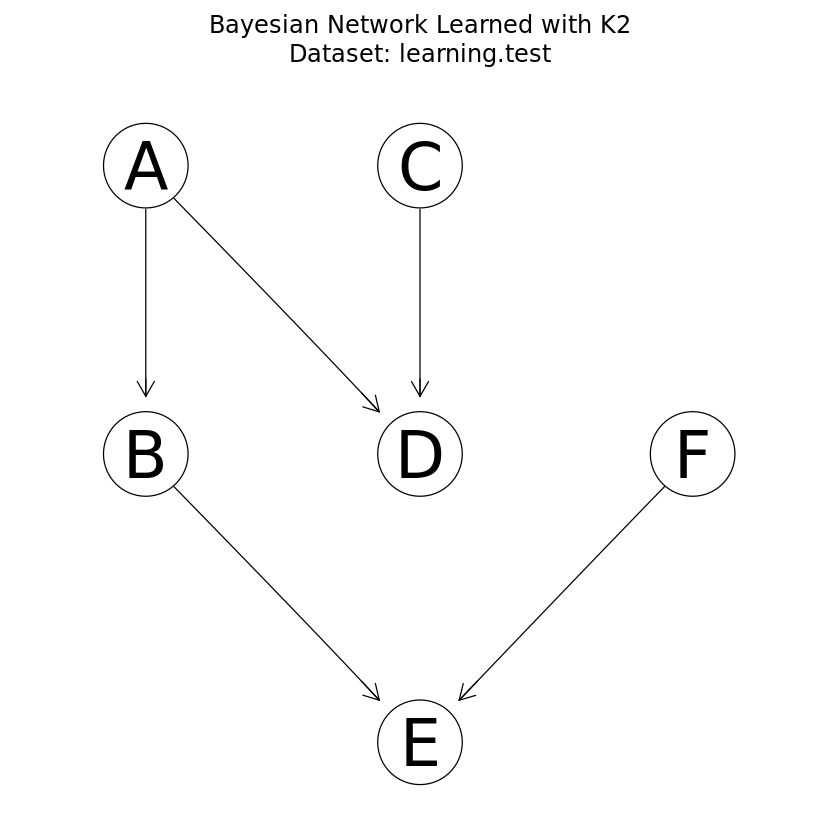

In [ ]:
learning.result.b <- brute.optim(learning.test, "learning.test", bruteforce=TRUE)

##### Simulated Annealing


Execution Time: 389.5913 s


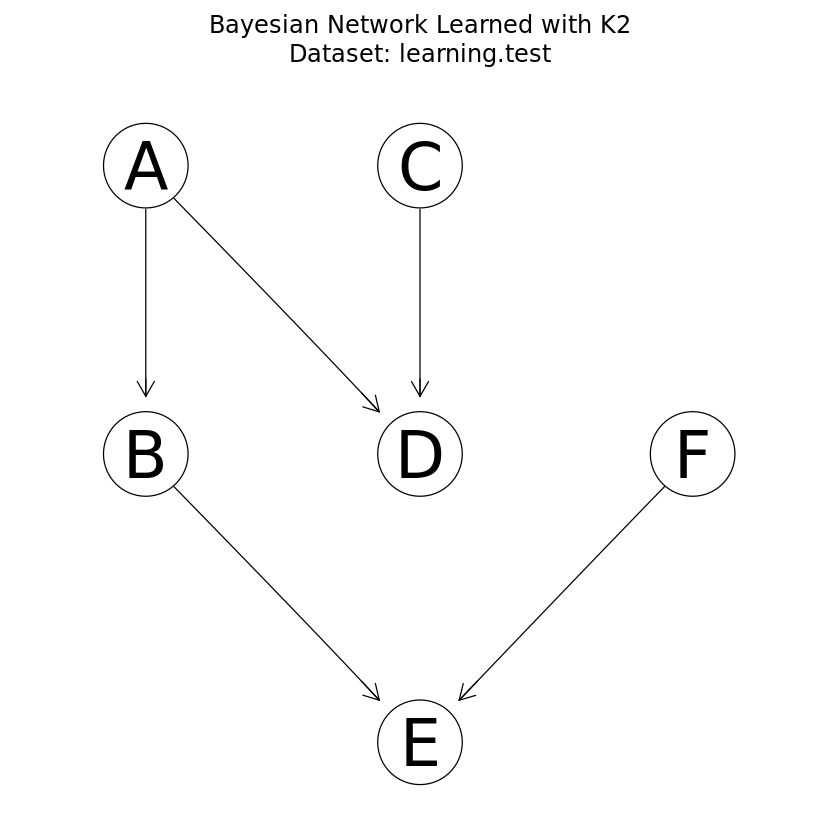

In [ ]:
learning.result.sann <- brute.optim(learning.test, "learning.test",1000,10,10)

### Asia

##### Bruteforce


Execution Time: 23554.39 s


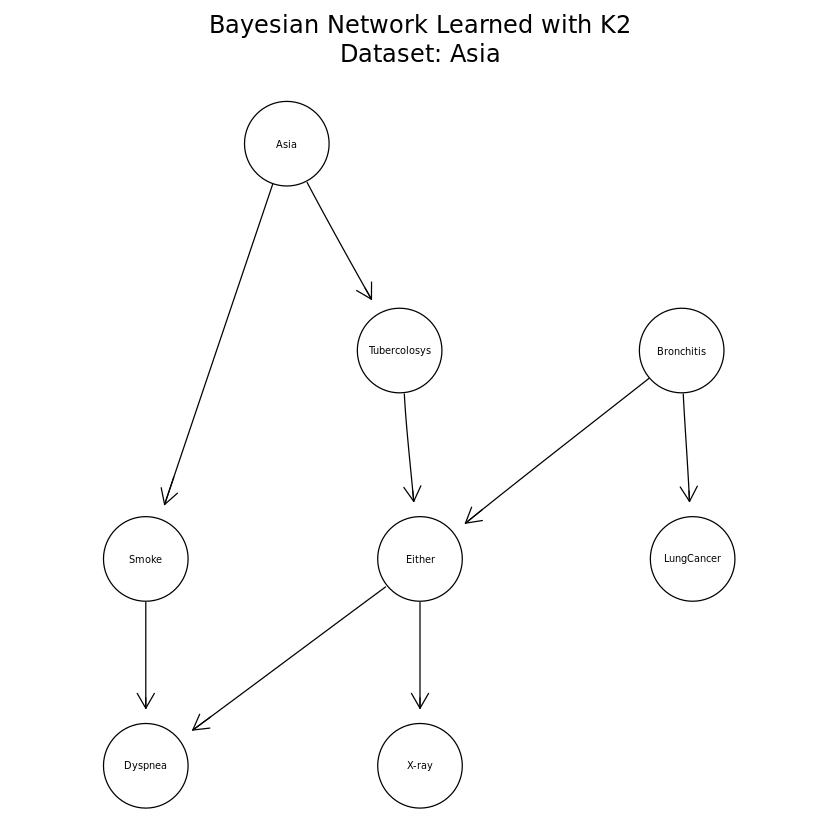

In [ ]:
asia.result.b <- brute.optim(dataset(asia()), "Asia", 2500, 100 ,75, bruteforce = TRUE)

##### Simulated Annealing


Execution Time: 5871.879 s


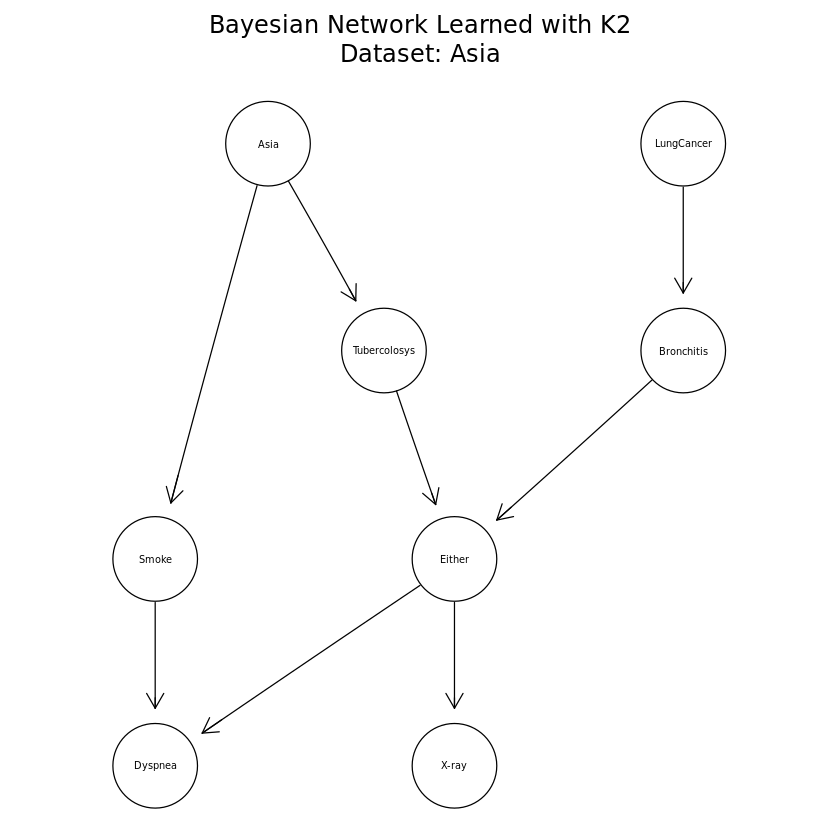

In [ ]:
asia.result.sann <- brute.optim(dataset(asia()), "Asia", 15000, 200 ,150)

### Child

##### Simulated Annealing


Execution Time: 93799.24 s


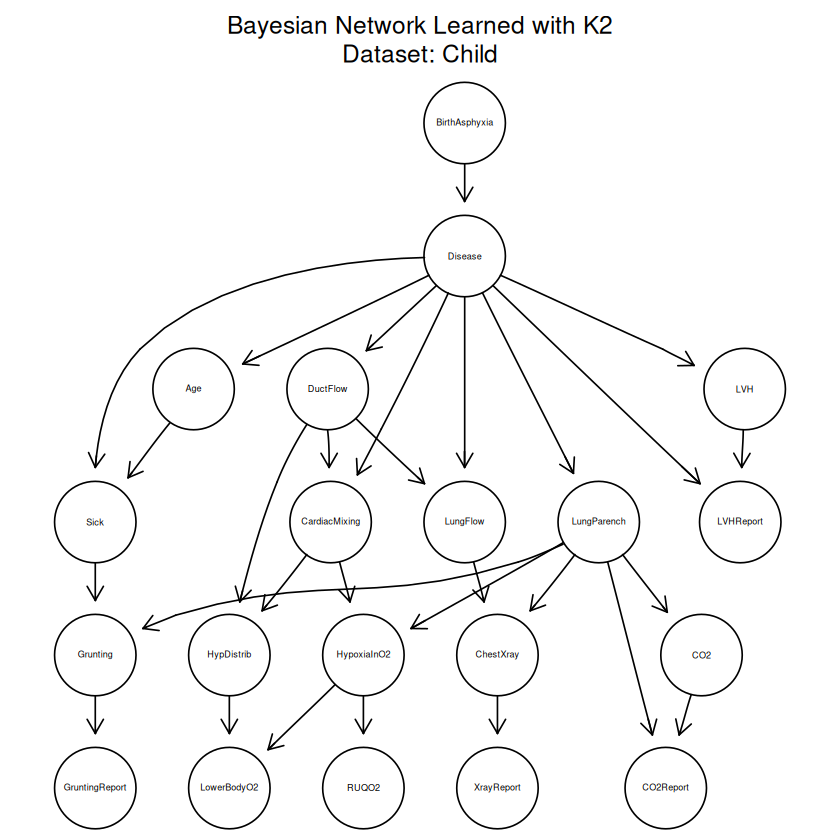

In [ ]:
child.result <- brute.optim(dataset(child()), "Child", 15000, 150, 150)

## Graphical Comparison

In [ ]:
#BN structures from documentation.

ruiz.paper.dag <- model2network("[x1][x2|x1][x3|x2]")
learning.library.dag <- model2network("[A][C][F][B|A][D|A:C][E|B:F]")
asia.library.dag <- model2network("[Asia][Smoke][Tubercolosys|Asia][LungCancer|Smoke][Bronchitis|Smoke][Dyspnea|Bronchitis:Either][Either|Tubercolosys:LungCancer][X-ray|Either]")
child.model.string <- paste0(
  "[BirthAsphyxia][Disease|BirthAsphyxia][Sick|Disease][Age|Disease:Sick][DuctFlow|Disease]",
    "[CardiacMixing|Disease][LungParench|Disease][LungFlow|Disease][LVH|Disease]",
    "[Grunting|Sick:LungParench][HypDistrib|DuctFlow:CardiacMixing][HypoxiaInO2|CardiacMixing:LungParench][CO2|LungParench][ChestXray|LungParench:LungFlow][LVHReport|LVH]",
    "[GruntingReport|Grunting][LowerBodyO2|HypDistrib:HypoxiaInO2][RUQO2|HypoxiaInO2][CO2Report|CO2][XrayReport|ChestXray]")

child.library.dag <- model2network(child.model.string)

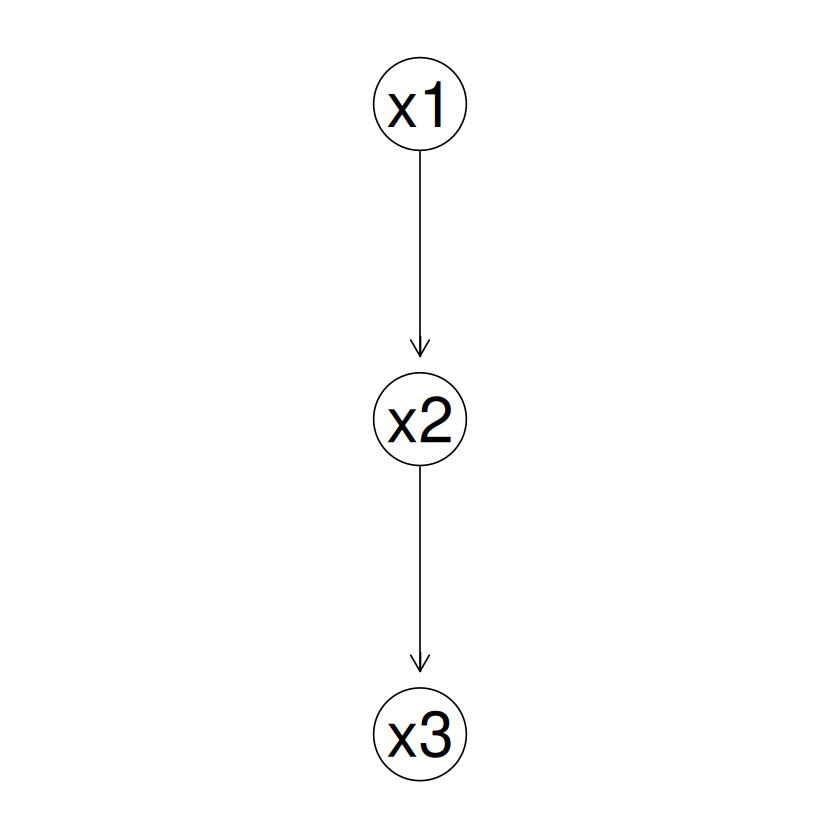

In [338]:
graphviz.compare(ruiz.paper.dag, ruiz.result$dag, shape="circle")

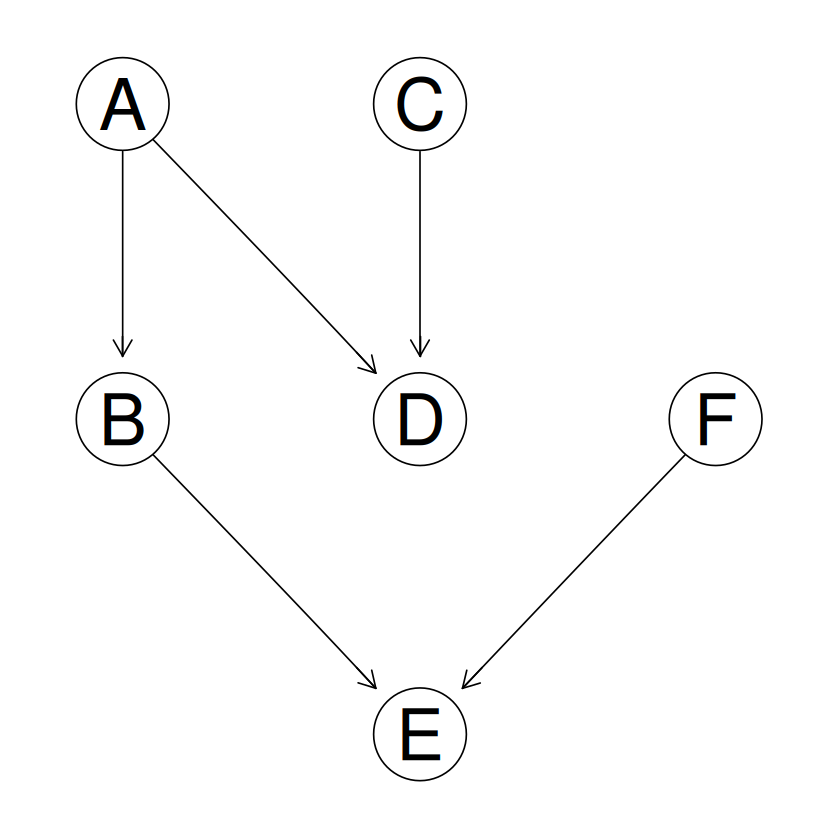

In [339]:
graphviz.compare(learning.library.dag, learning.result$dag, shape = "circle")

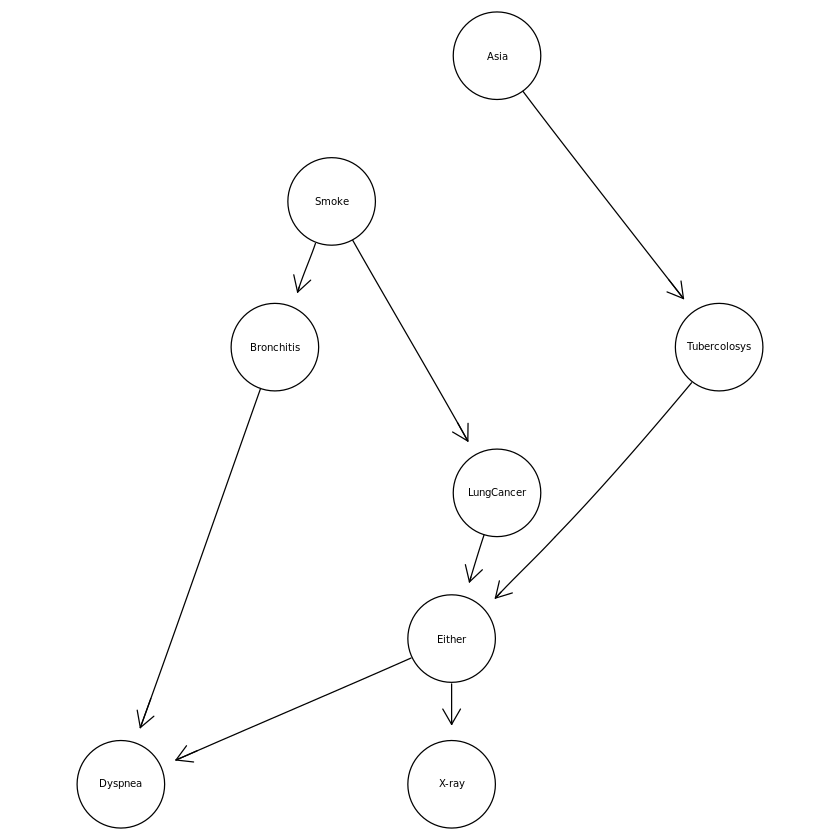

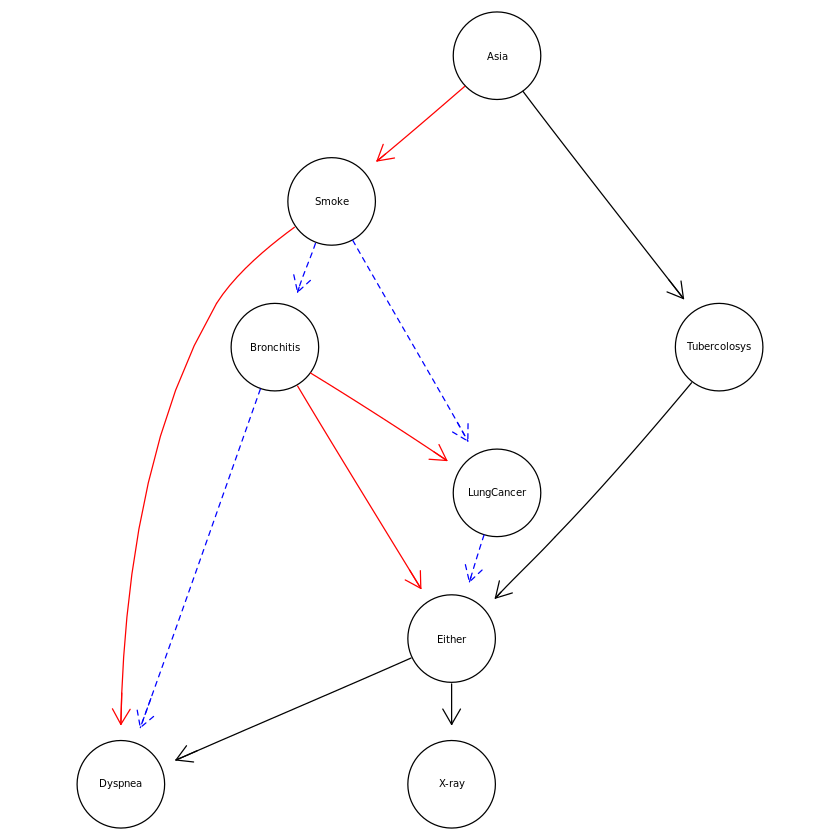

In [19]:
graphviz.compare(asia.library.dag, asia.result.b$dag, shape = "circle")

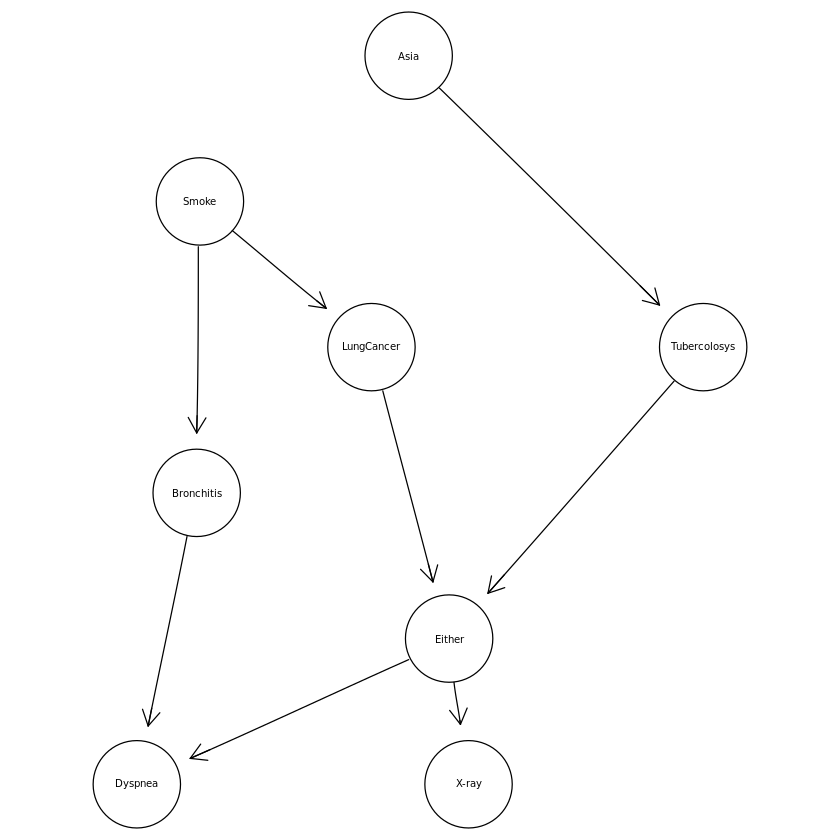

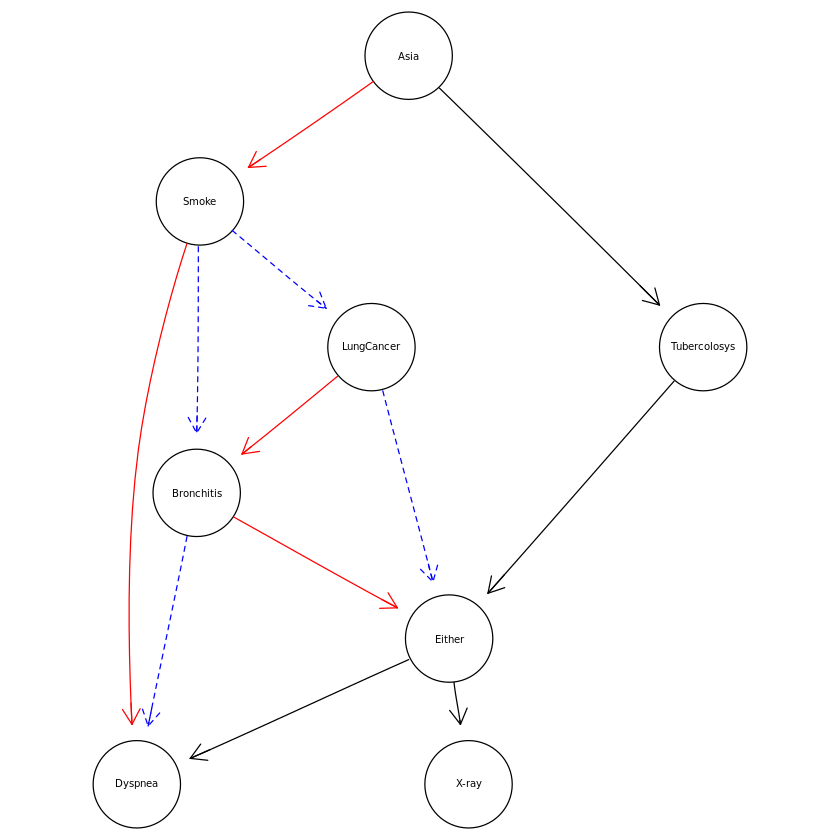

In [12]:
graphviz.compare(asia.library.dag, asia.result.sann$dag, shape = "circle")

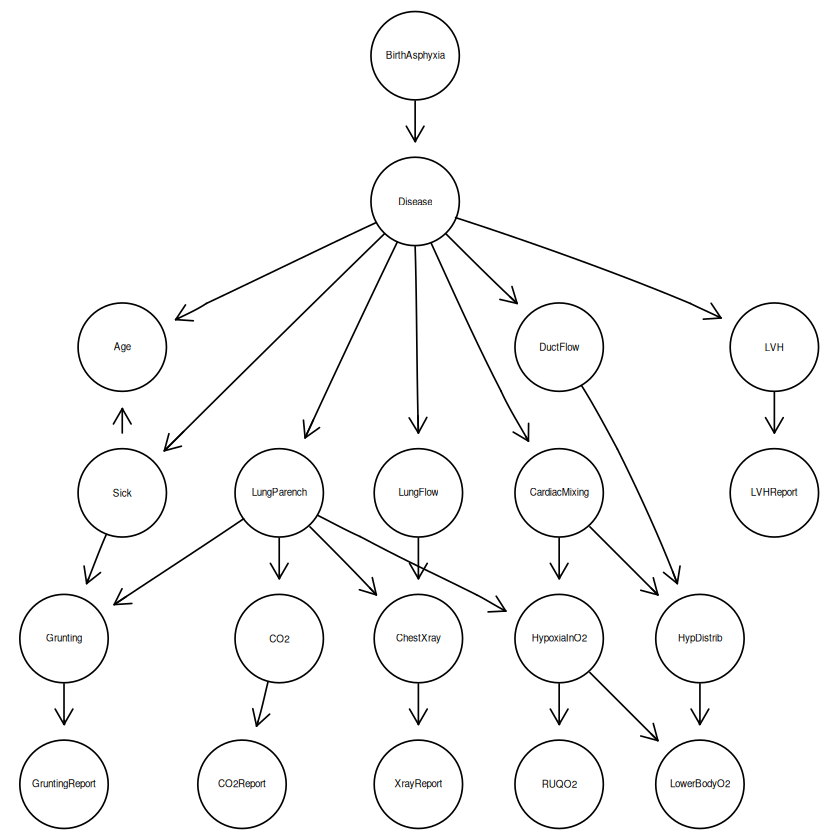

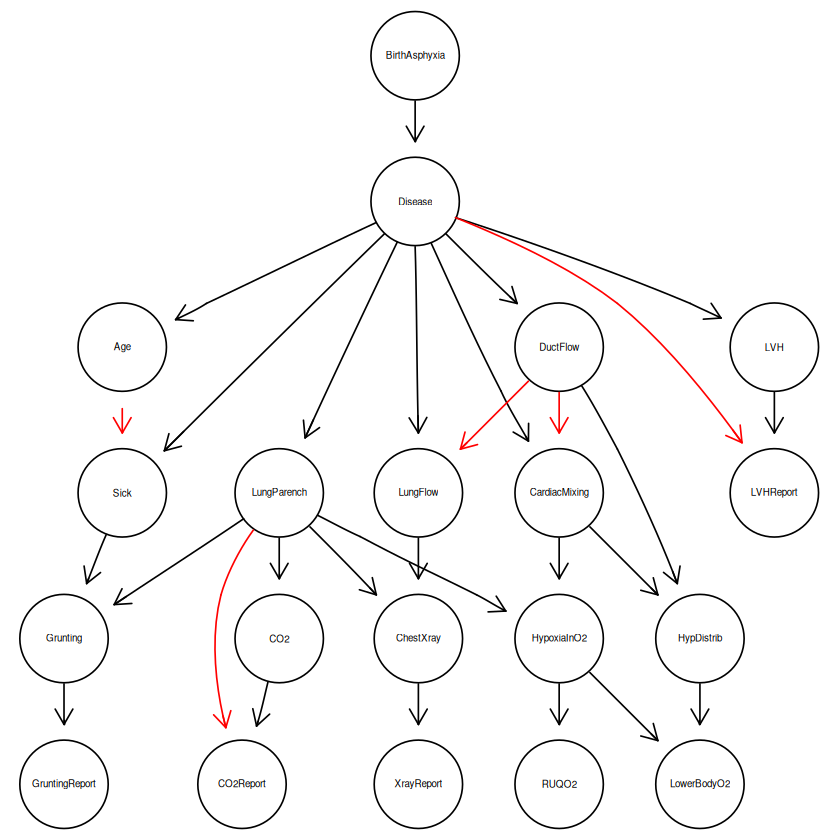

In [11]:
graphviz.compare(child.library.dag, child.result$dag, shape = "circle")

# Part 2: `bnstruct` library
Implement and test the K2 algorithm with the test data sets ([3]). Compare the results with that obtained with the bnstruct R library [4].

In this Section we show the results obtained by `MMHC` on available cases, `MMHC` on imputed data and `SEM`, with the `BDeu` and `BIC` scoring functions.

### Useful functions

In [ ]:
# from data.frame to BNDataset
df.to.BND <- function(dataframe) {
    df_name <- deparse(substitute(dataframe))  # to retrieve the name as a string
    new.BNDataset <- BNDataset(data = dataframe,
                          discreteness = rep("d", ncol(dataframe)),
                          variables = colnames(dataframe),
                          node.sizes = c(sapply(dataframe, function(col) length(unique(col)))),
                          starts.from = 0,  # otherwise it starts from 1 to |x| that here is also 1
                          bndataset.name = paste0(df_name, ".dataset"))
    return(new.BNDataset)
}                   

In [ ]:
factor_remover <- function(dataset) {
    cols <- colnames(dataset)
    for (i in seq_along(cols)) {
        name <- cols[i]
        dataset[[name]] <- as.character(dataset[[name]])
    }
    return(dataset)
}


dataset <- function(dataset) {
    if (class(dataset) == 'data.frame') {
        return(factor_remover(dataset))
    } else if (class(dataset) == 'BNDataset') {
        df <- as.data.frame(raw.data(dataset))
        colnames(df) <- dataset@variables
        return(df)
    }
    else {
        ruiz <- data.frame(x1 = c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0),
                          x2 = c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0),
                          x3 = c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0))
        return(ruiz)
    }
}

**PROBLEM**: `learn.network` returns an object of class **BN** which is not compatible with `graphviz.plot()` from `bnlearn` (which takes in input **bn** objects), so it's used `plot` instead.<br>The alternative solution is to convert from **BN** $\rightarrow$ **bn** manually extracting the adjacency matrix or arc list and rebuild the structure with `bnlearn`.

In [ ]:
learn_network <- function(dataset, impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BDeu") {     #takes in input BNDataset
    start <- Sys.time()
    
    if (impute) {
        message("Imputing dataset")
        dataset <- impute(dataset)
    }
      
    if (impute && bootstrap) {
        message("Learning network imputing NA, then bootstrap.")
        net <- learn.network(dataset, 
                             use.imputed.data = TRUE,
                             bootstrap = TRUE, 
                             algo = algo,
                             score.fun = score.fun)
    } else if (impute) {
        message("Learning network using imputed data.")
        net <- learn.network(dataset, 
                             use.imputed.data = TRUE,
                             algo = algo,
                             score.fun = score.fun)
    } else if (bootstrap) {
        message("Learning network using bootstrap.")
        net <- learn.network(dataset, 
                             bootstrap = TRUE,
                             algo = algo,
                             score.fun = score.fun)
    } else {
        message("Learning network using default method.")
        net <- learn.network(dataset,
                             algo = algo,
                             score.fun = score.fun)
    }
    
    # Plot
    plot(net)
    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    cat("\nExecution Time:", execution_time, "s")
        
    return(net)
}

## Inspecting Dataset with `bnstruct`

We use `learn.network` with `mmhc` algo and two scoring functions: `BDeu` and `BIC`.

### Ruiz Dataset
All the params combinations are:
| impute | bootstrap | algo | score.fun |
|--------|-----------|------|-----------|
| FALSE  | FALSE     | mmhc | BDeu      |
| FALSE  | FALSE     | mmhc | BIC       |

In [ ]:
ruiz.dataset <- dataset("ruiz") |> df.to.BND()

Learning network using default method.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 0.1650019 s

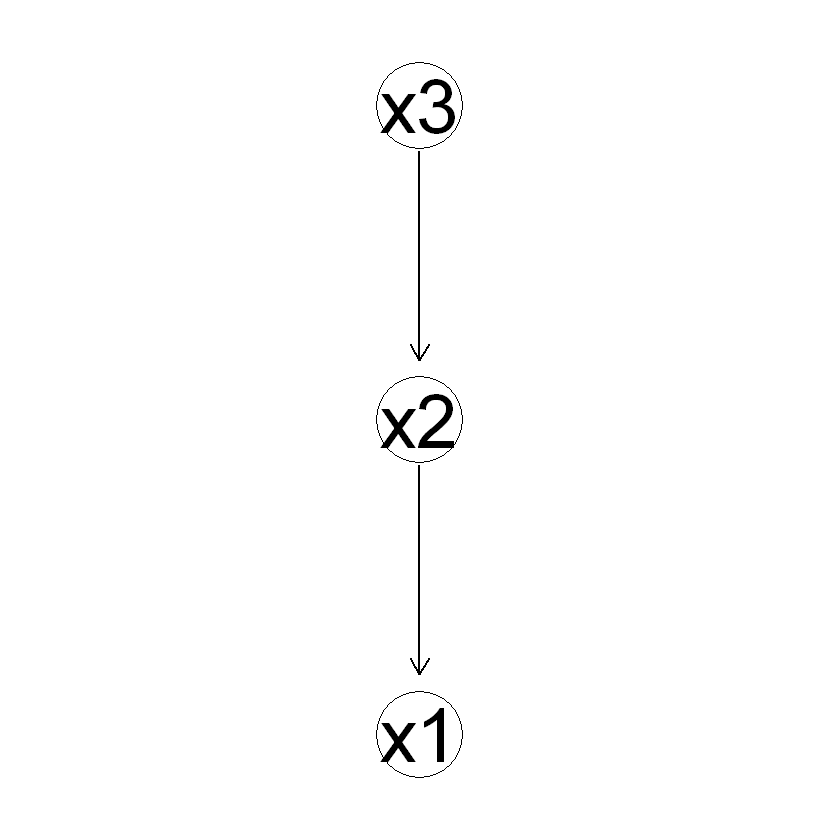

In [ ]:
ruiz.net <- learn_network(dataset = ruiz.dataset, algo="mmhc", score.fun="BDeu")

Learning network using default method.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 0.26758 s

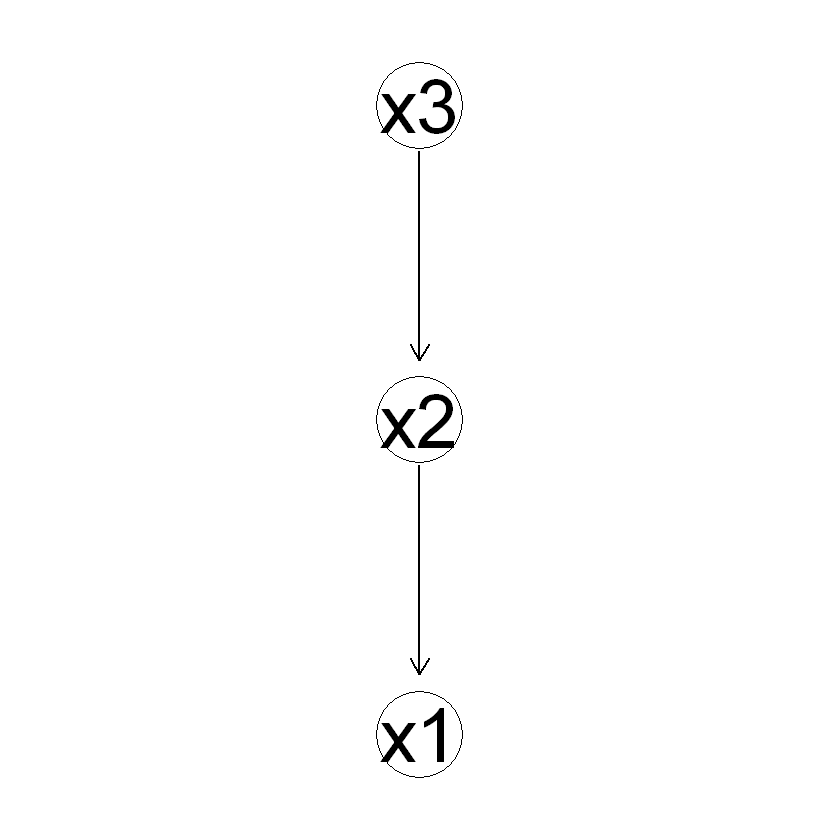

In [ ]:
ruiz.bic.net <- learn_network(dataset = ruiz.dataset, algo="mmhc", score.fun="BIC")

### learning.test Dataset
All the params combinations are:
| impute | bootstrap | algo | score.fun |
|--------|-----------|------|-----------|
| FALSE  | FALSE     | mmhc | BDeu      |
| FALSE  | FALSE     | mmhc | BIC       |

In [ ]:
learning.dataset <- data.frame(lapply(learning.test, function(col) as.integer(as.factor(col)) - 1)) |> df.to.BND()

Learning network using default method.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 0.137157 s

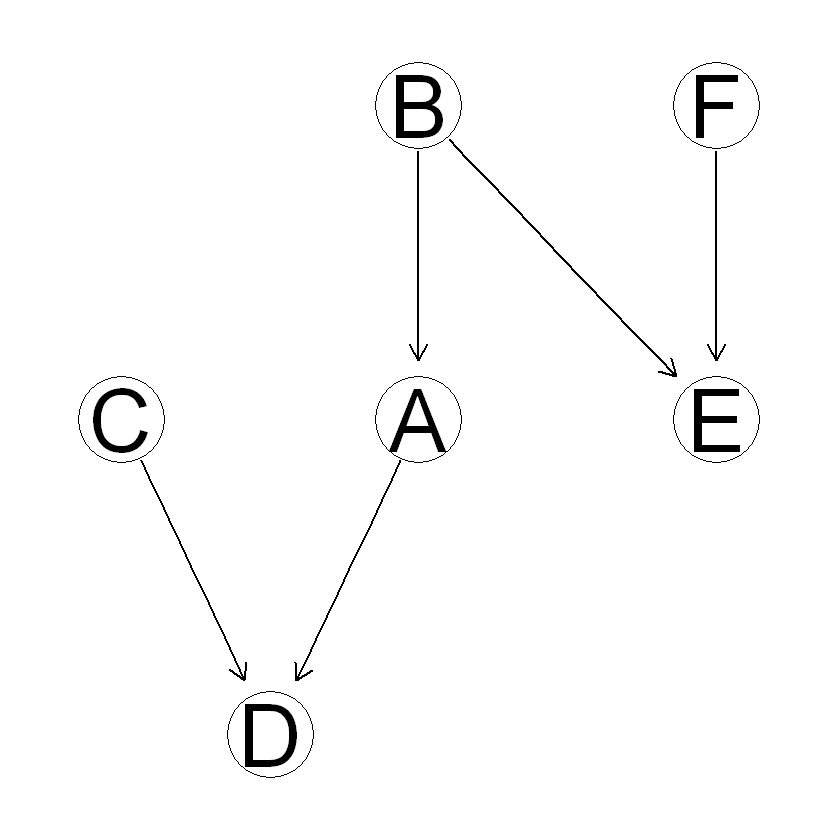

In [ ]:
learning.net <- learn_network(dataset = learning.dataset, algo="mmhc", score.fun="BDeu")

Learning network using default method.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 0.1348732 s

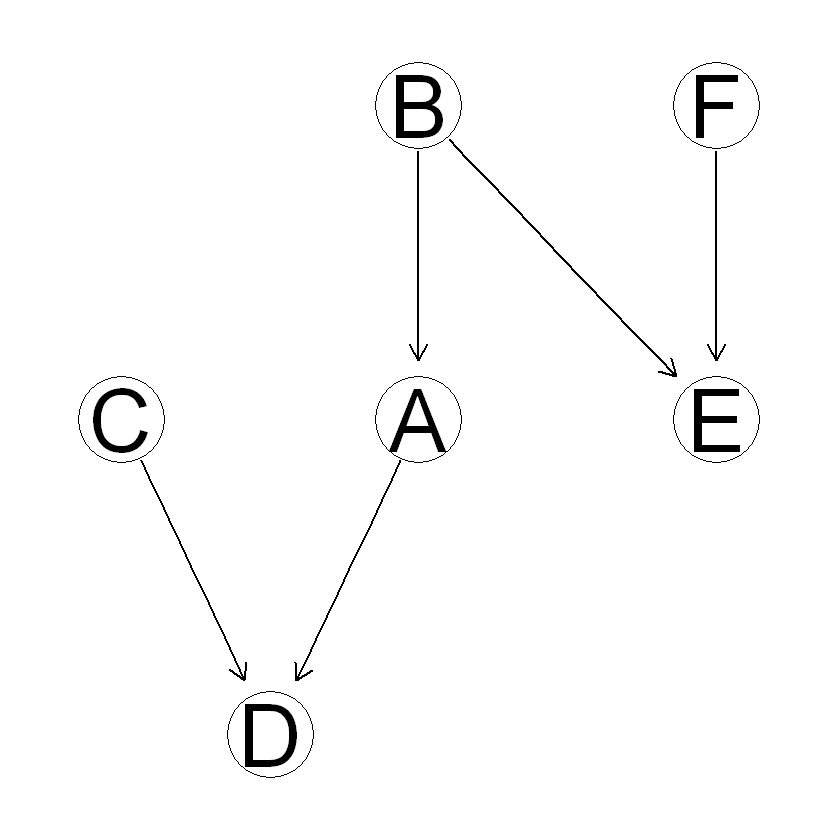

In [ ]:
learning.net.bic <- learn_network(dataset = learning.dataset, algo="mmhc", score.fun="BIC")

### Asia Dataset
We also perform bootstrap so all the params combinations are:
| impute | bootstrap | algo | score.fun |
|--------|-----------|------|-----------|
| FALSE  | FALSE     | mmhc | BDeu      |
| FALSE  | FALSE     | mmhc | BIC       |
| FALSE   | TRUE     | mmhc | BDeu      |
| FALSE   | TRUE     | mmhc | BIC       |


Learning network using default method.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 0.2536869 s

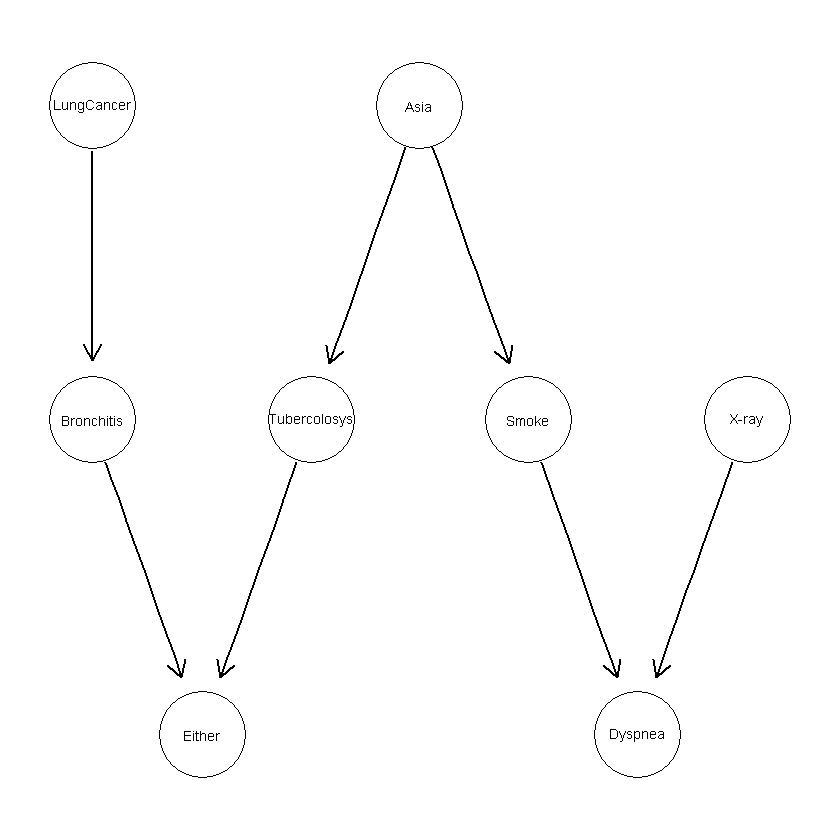

In [ ]:
asia.net <- learn_network(dataset = asia(), impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BDeu")

Learning network using default method.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 0.2357218 s

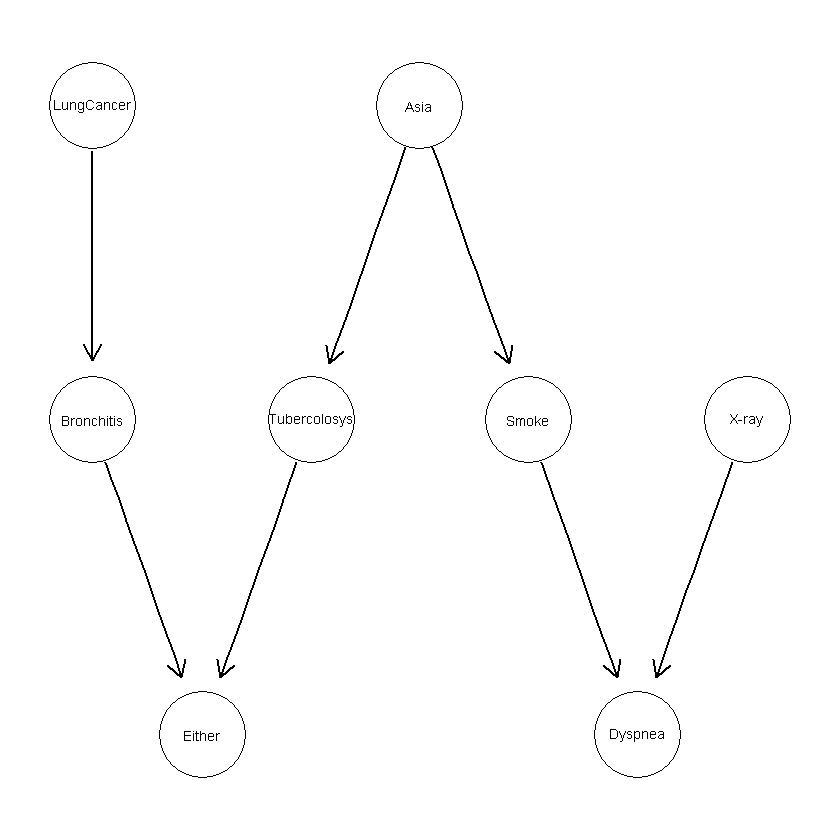

In [ ]:
asia.bic.net <- learn_network(dataset = asia(), impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BIC")

Bootstrap on Asia dataset with $\text{bootstrap} = 100$.

In [ ]:
asia.bootstrapped <- bootstrap(asia(), num.boots = 100, imputation = FALSE)

bnstruct :: Generating bootstrap samples ...

bnstruct :: Bootstrap samples generated.



Learning network using bootstrap.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.




Execution Time: 9.272174 s

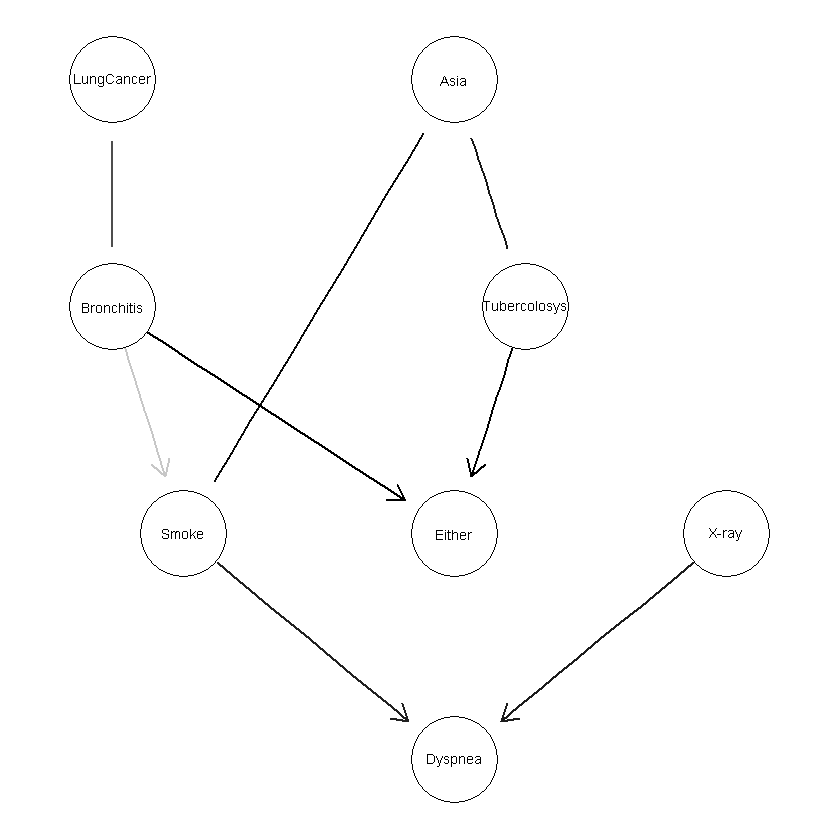

In [ ]:
asia_net <- learn_network(dataset = asia.bootstrapped, impute = FALSE, bootstrap = TRUE, algo = "mmhc", score.fun = "BDeu")

Learning network using bootstrap.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.




Execution Time: 8.801947 s

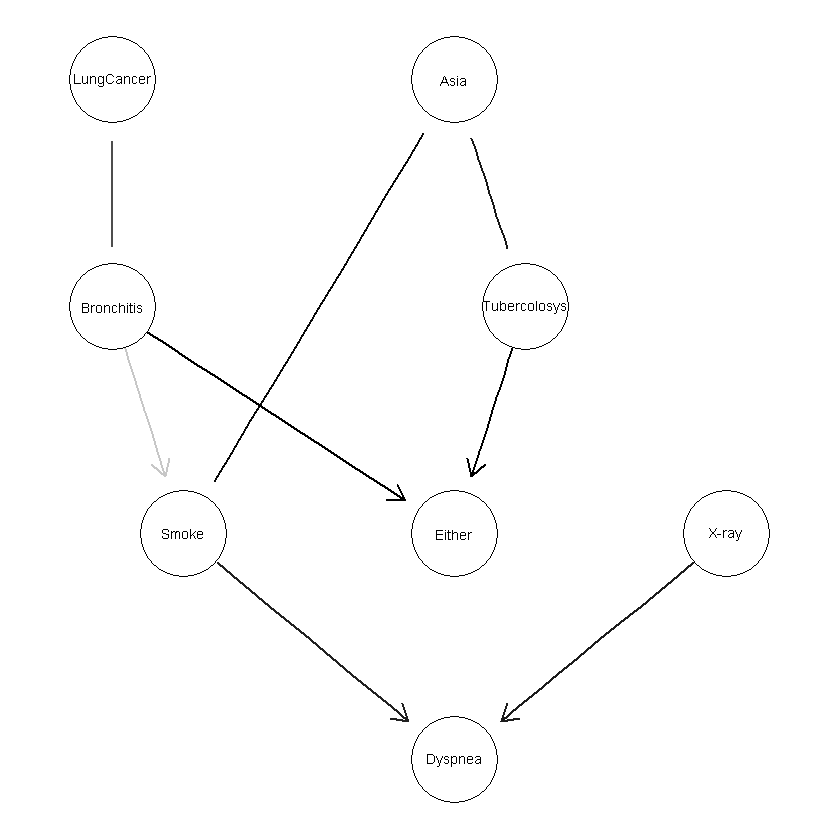

In [ ]:
asia_net <- learn_network(dataset = asia.bootstrapped, impute = FALSE, bootstrap = TRUE, algo="mmhc", score.fun="BIC")

### Child Dataset
We perform imputation so all the params combinations are:
| impute | bootstrap | algo | score.fun |
|--------|-----------|------|-----------|
| FALSE  | FALSE     | mmhc | BDeu      |
| FALSE  | FALSE     | mmhc | BIC       |
| FALSE  | FALSE     | sem  | BDeu      |
| TRUE  | FALSE     | mmhc | BDeu      |
| TRUE  | FALSE     | mmhc | BIC       |

Learning network using default method.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 3.453288 s

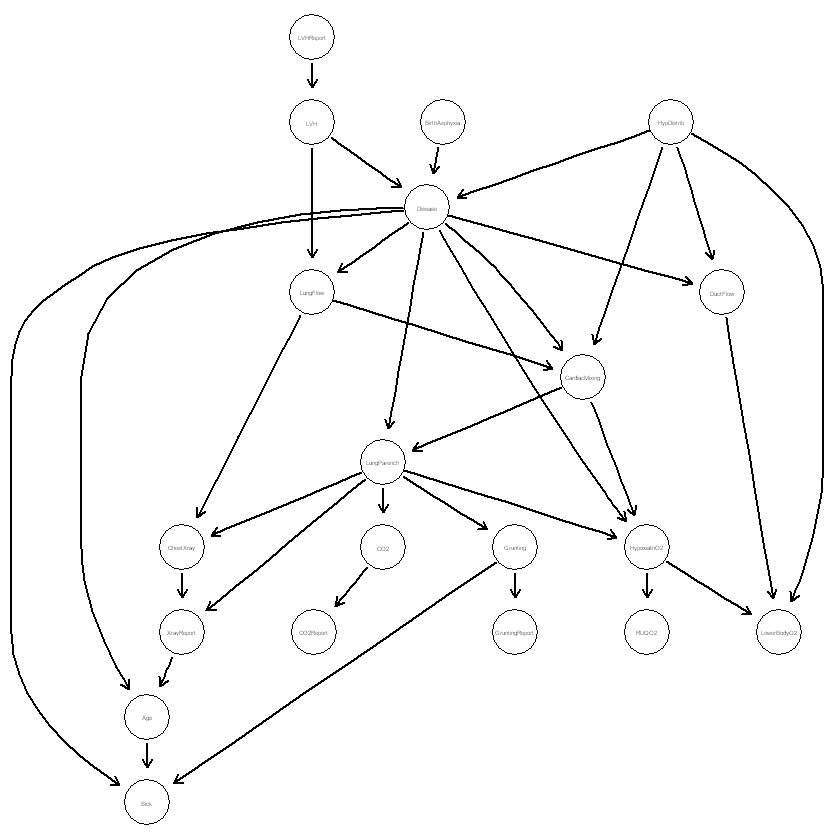

In [ ]:
child_net <- learn_network(dataset = child(), impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BDeu")

Learning network using default method.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 3.511201 s

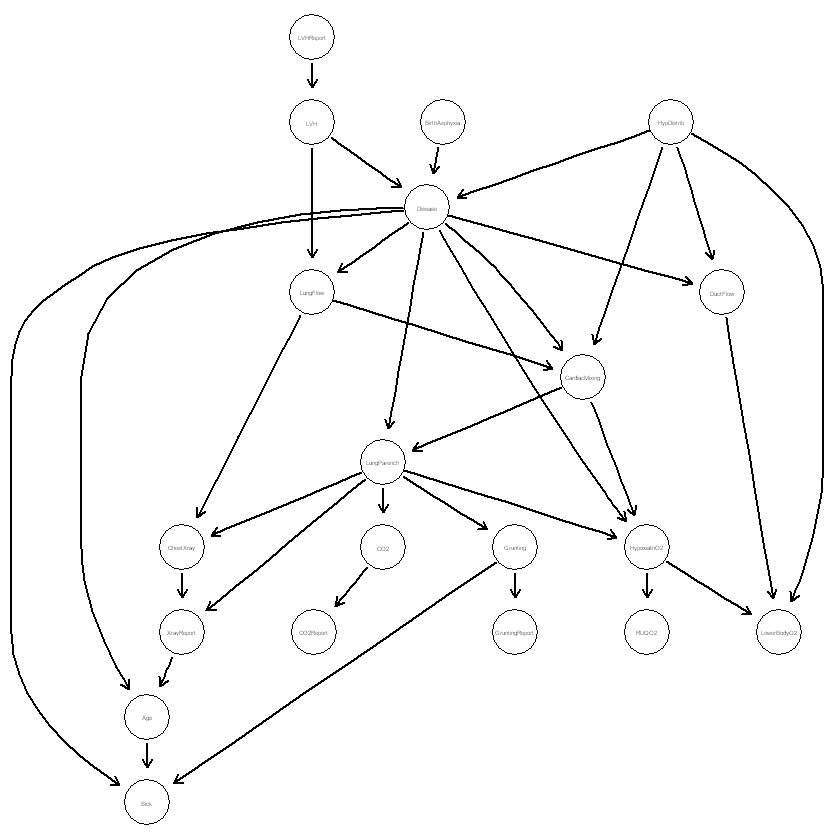

In [ ]:
child.bnstruct.net <- learn_network(dataset = child(), impute = FALSE, bootstrap = FALSE, algo="mmhc", score.fun="BIC")

Learning network using default method.

bnstruct :: learning the structure using SEM ...

... bnstruct :: starting EM algorithm ...

... ... bnstruct :: learning network parameters ... 

... ... bnstruct :: parameter learning done.

... ... bnstruct :: learning network parameters ... 

... ... bnstruct :: parameter learning done.

... bnstruct :: EM algorithm completed.

... bnstruct :: learning the structure using MMHC ...

... bnstruct :: learning using MMHC completed.

... bnstruct :: learning network parameters ... 

... bnstruct :: parameter learning done.

... bnstruct :: starting EM algorithm ...

... ... bnstruct :: learning network parameters ... 

... ... bnstruct :: parameter learning done.

Warning message:
"Combining vertex/edge sequences from different graphs.
✖ This will not work in future igraph versions."
Warning message:
"Combining vertex/edge sequences from different graphs.
✖ This will not work in future igraph versions."
... ... bnstruct :: learning network paramet


Execution Time: 1153.185 s

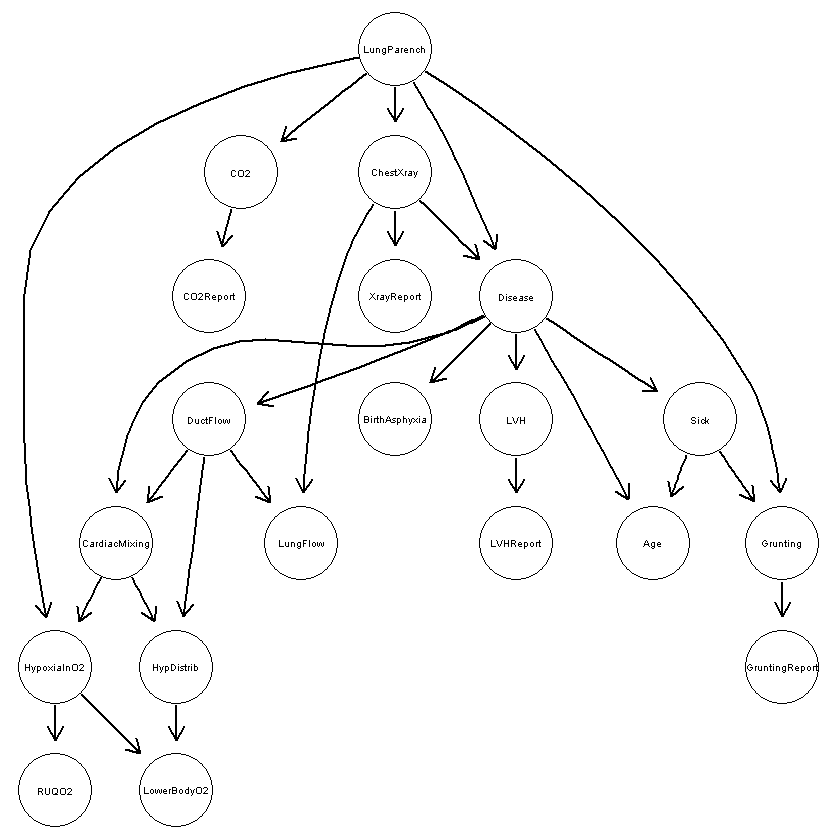

In [ ]:
child_net <- learn_network(dataset = child(), impute = FALSE, bootstrap = FALSE, algo="sem", score.fun="BDeu")

In [ ]:
child.imputed <- impute(object = child())

bnstruct :: performing imputation ...

bnstruct :: imputation finished.



Imputing dataset

bnstruct :: performing imputation ...

bnstruct :: imputation finished.

Learning network using imputed data.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 15.58583 s

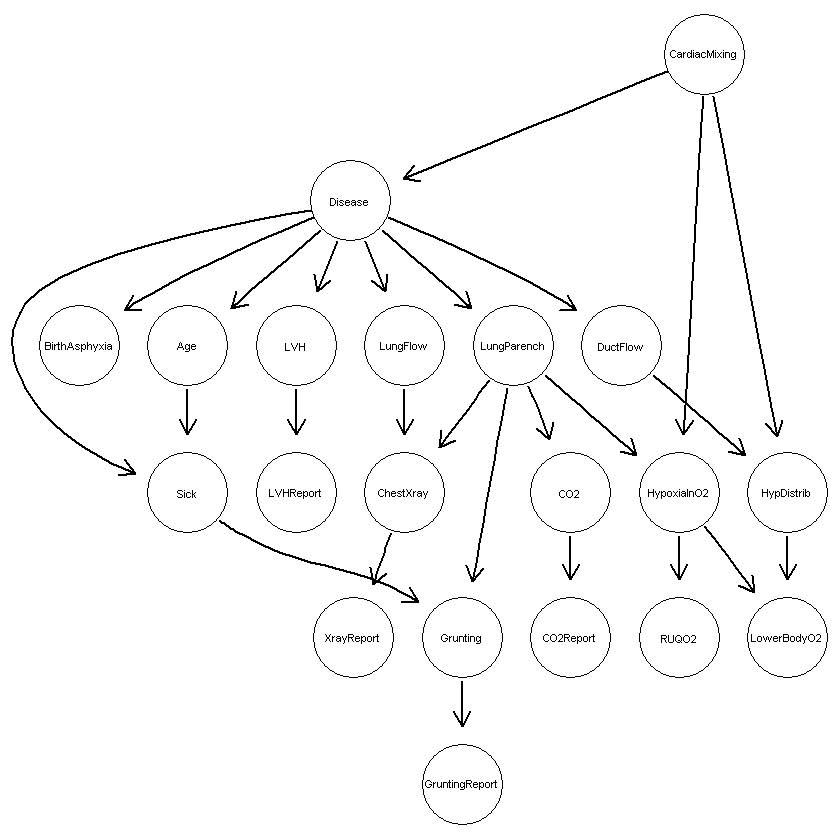

In [ ]:
child_net <- learn_network(dataset = child.imputed, impute = TRUE, bootstrap = FALSE, algo="mmhc", score.fun="BDeu")

Imputing dataset

bnstruct :: performing imputation ...

bnstruct :: imputation finished.

Learning network using imputed data.

bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.




Execution Time: 16.20282 s

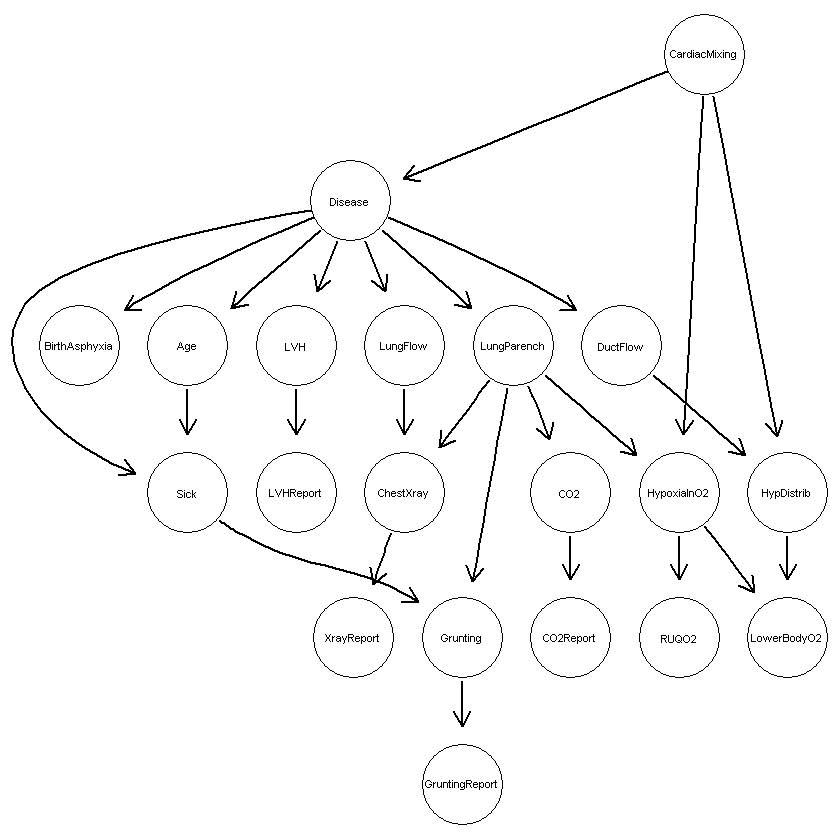

In [ ]:
child_net <- learn_network(dataset = child.imputed, impute = TRUE, bootstrap = FALSE, algo="mmhc", score.fun="BIC")

## Graphical Comparison

using the DAG obtained in the first part with the K2 algorithm and the results obtained in the previous point with the `BIC` score.

In [ ]:
ruiz.k2.dag <- model2network("[x1][x2|x1][x3|x2]")
learning.k2.dag <- model2network("[A][C][F][B|A][D|A:C][E|B:F]")
asia.brute.dag <- model2network("[Asia][Bronchitis][Tubercolosys|Asia][Smoke|Asia][LungCancer|Bronchitis][Either|Tubercolosys:Bronchitis][Dyspnea|Smoke:Either][X-ray|Either]")
asia.sann.dag <- model2network("[Asia][LungCancer][Bronchitis|LungCancer][Tubercolosys|Asia][Smoke|Asia][Either|Tubercolosys:Bronchitis][Dyspnea|Smoke:Either][X-ray|Either]")
child.sann.dag <- model2network( "[BirthAsphyxia][Disease|BirthAsphyxia][Age|Disease][LVH|Disease][DuctFlow|Disease][LungParench|Disease][CardiacMixing|Disease:DuctFlow][LungFlow|Disease:DuctFlow][Sick|Disease:Age][CO2|LungParench][LVHReport|Disease:LVH][HypDistrib|DuctFlow:CardiacMixing][HypoxiaInO2|CardiacMixing:LungParench][ChestXray|LungParench:LungFlow][Grunting|LungParench:Sick][CO2Report|LungParench:CO2][LowerBodyO2|HypDistrib:HypoxiaInO2][RUQO2|HypoxiaInO2][XrayReport|ChestXray][GruntingReport|Grunting]")

In [ ]:
ruiz.bnstruct.dag <- model2network("[x3][x2|x3][x1|x2]")
learning.bnstruct.dag <- model2network("[C][F][B][A|B][D|A:C][E|B:F]")

asia.bnstruct.dag <- model2network("[Asia][LungCancer][X-ray][Tubercolosys|Asia][Smoke|Asia][Bronchitis|LungCancer][Either|Tubercolosys:Bronchitis][Dyspnea|Smoke:X-ray]")

model_string <- paste0("[CardiacMixing]",
                       "[Disease|CardiacMixing]",
                       "[BirthAsphyxia|Disease][Age|Disease][LVH|Disease][LungFlow|Disease][LungParench|Disease][DuctFlow|Disease]",
                       "[Sick|Disease:Age][LVHReport|LVH][ChestXray|LungFlow:LungParench][CO2|LungParench][HypoxiaInO2|LungParench:CardiacMixing][HypDistrib|DuctFlow:CardiacMixing]",
                       "[XrayReport|ChestXray][Grunting|LungParench:Sick][CO2Report|CO2][RUQO2|HypoxiaInO2][LowerBodyO2|HypoxiaInO2:HypDistrib]",
                       "[GruntingReport|Grunting]"
)
child.imputed.bnstruct.dag <- model2network(model_string)

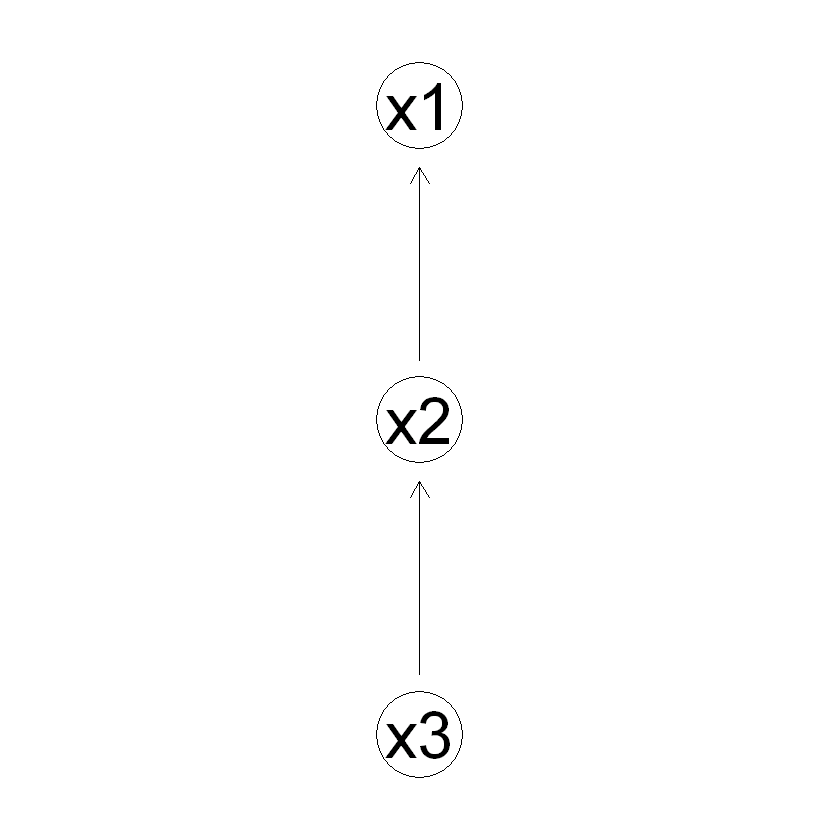

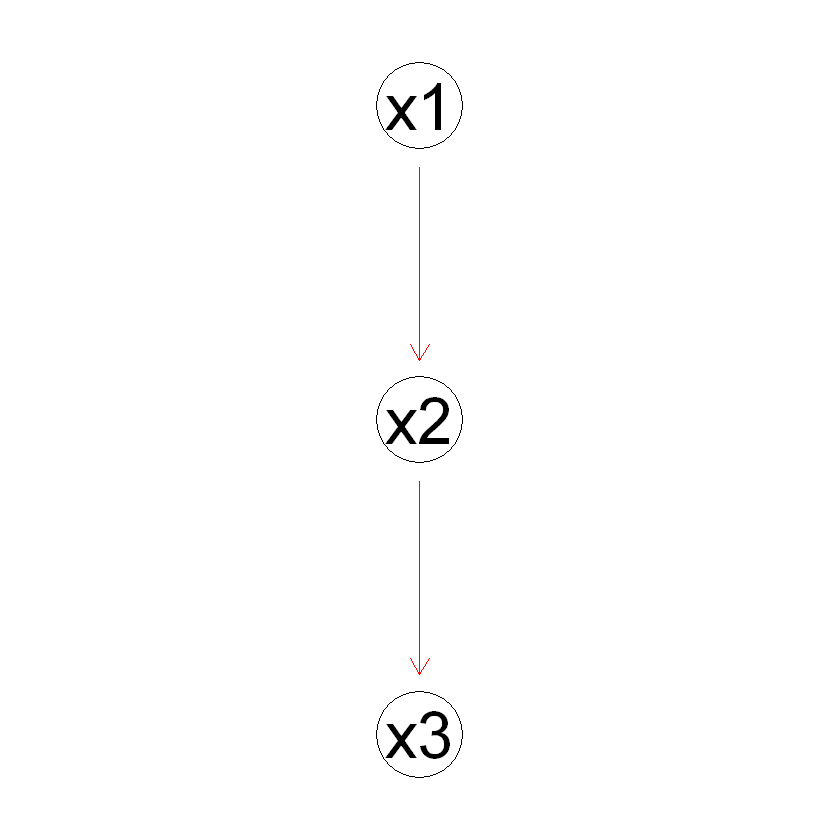

In [ ]:
graphviz.compare(ruiz.bnstruct.dag, ruiz.k2.dag, shape="circle")

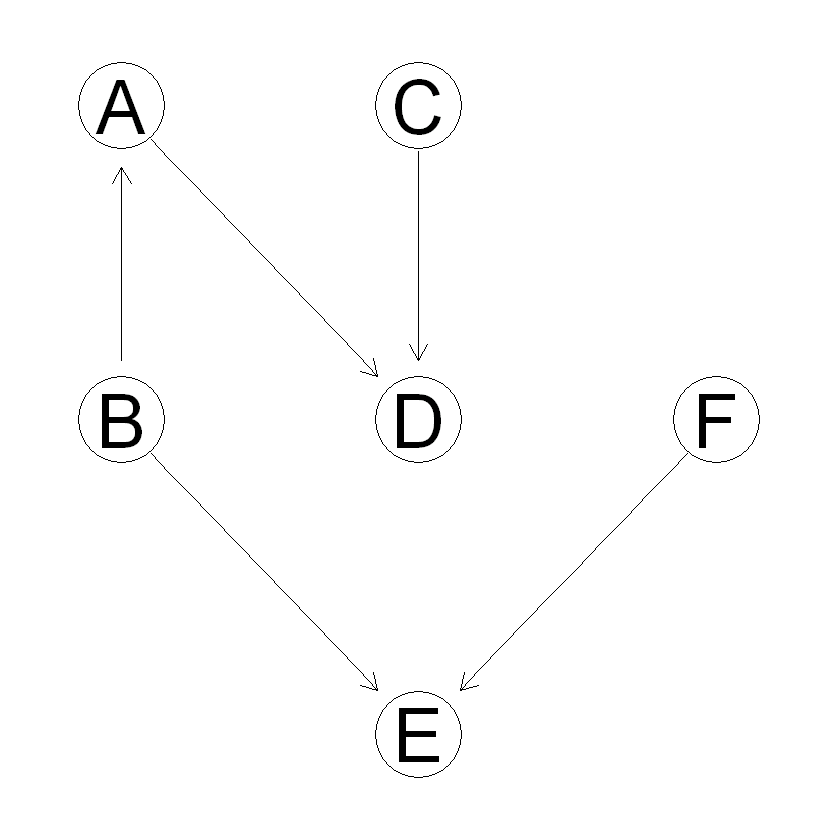

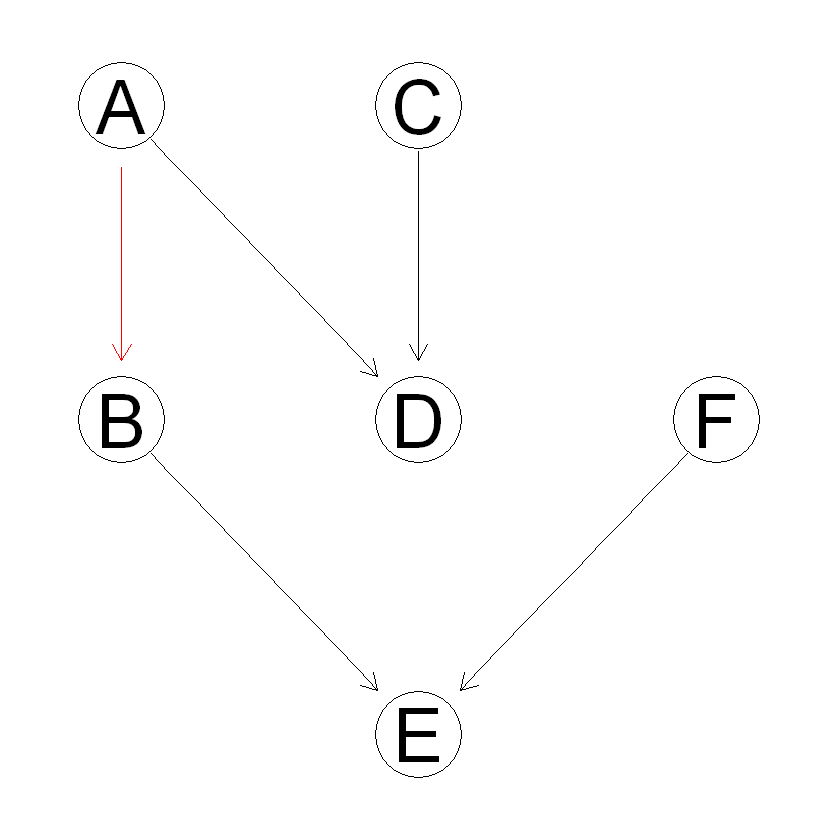

In [ ]:
graphviz.compare(learning.bnstruct.dag, learning.k2.dag, shape="circle")

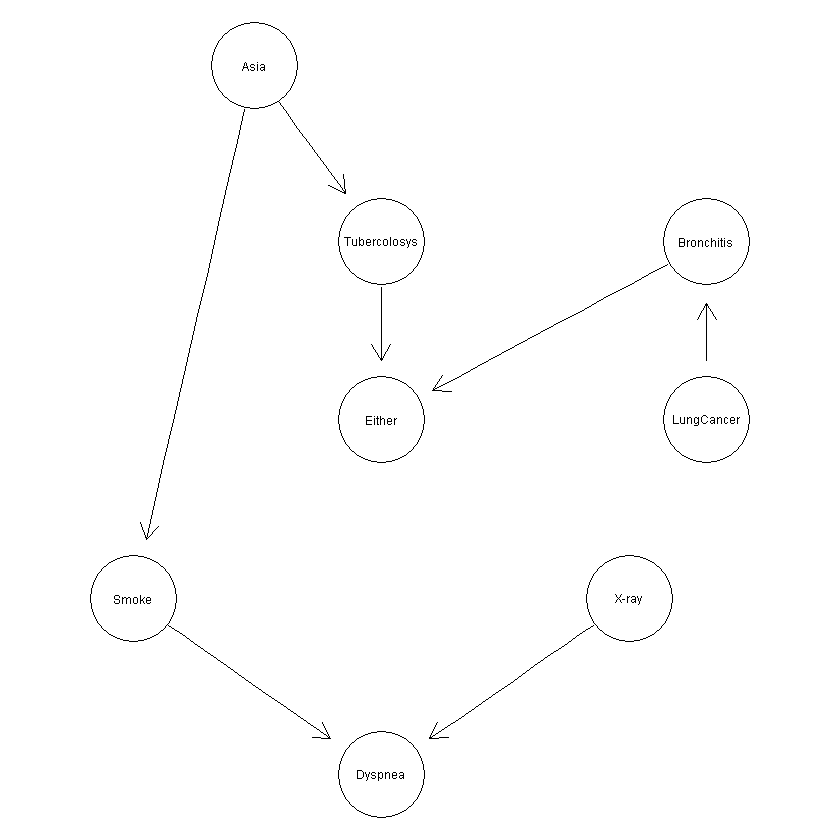

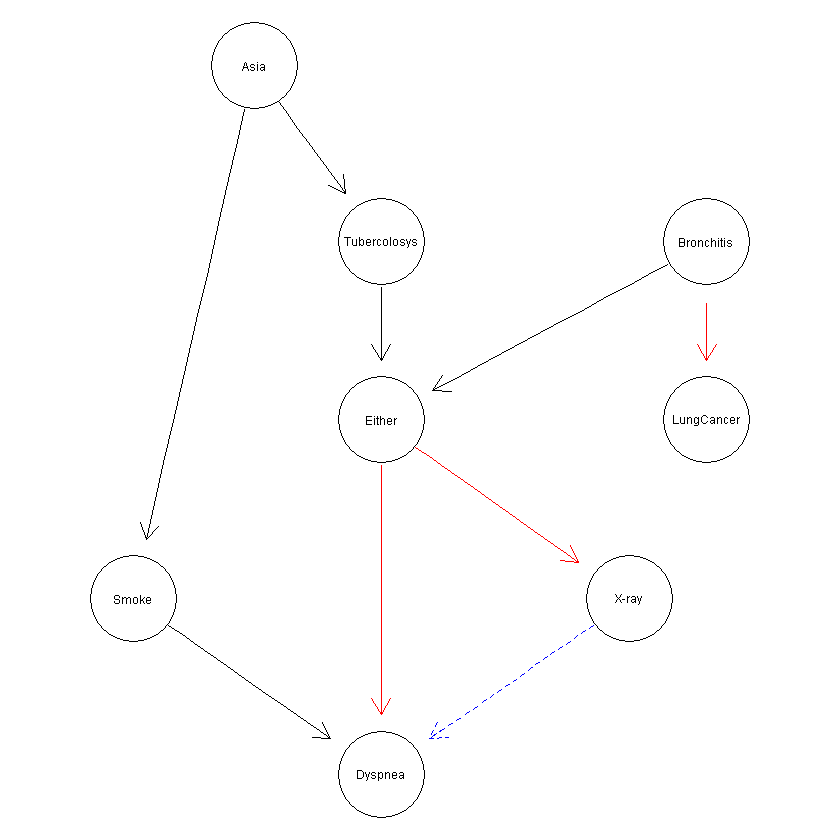

In [ ]:
graphviz.compare(asia.bnstruct.dag, asia.brute.dag, shape="circle")

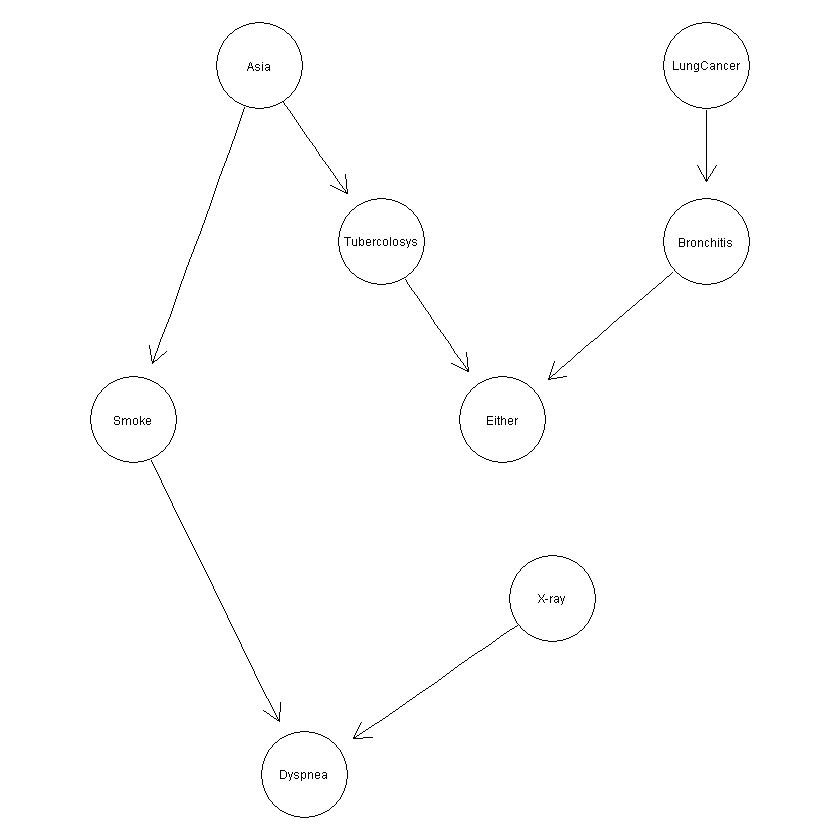

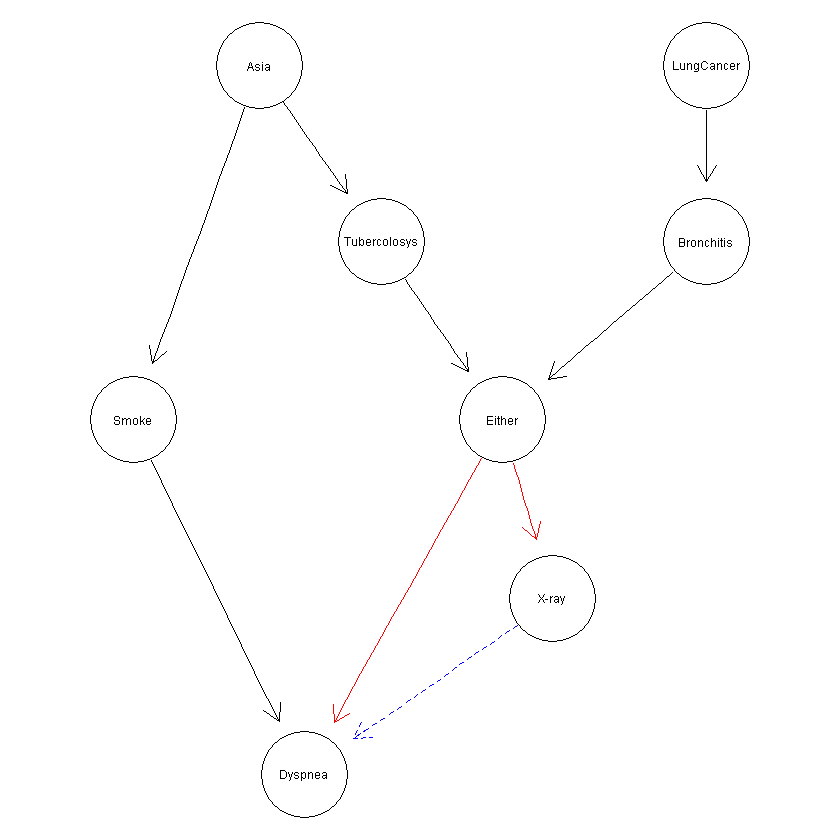

In [ ]:
graphviz.compare(asia.bnstruct.dag, asia.sann.dag, shape="circle")

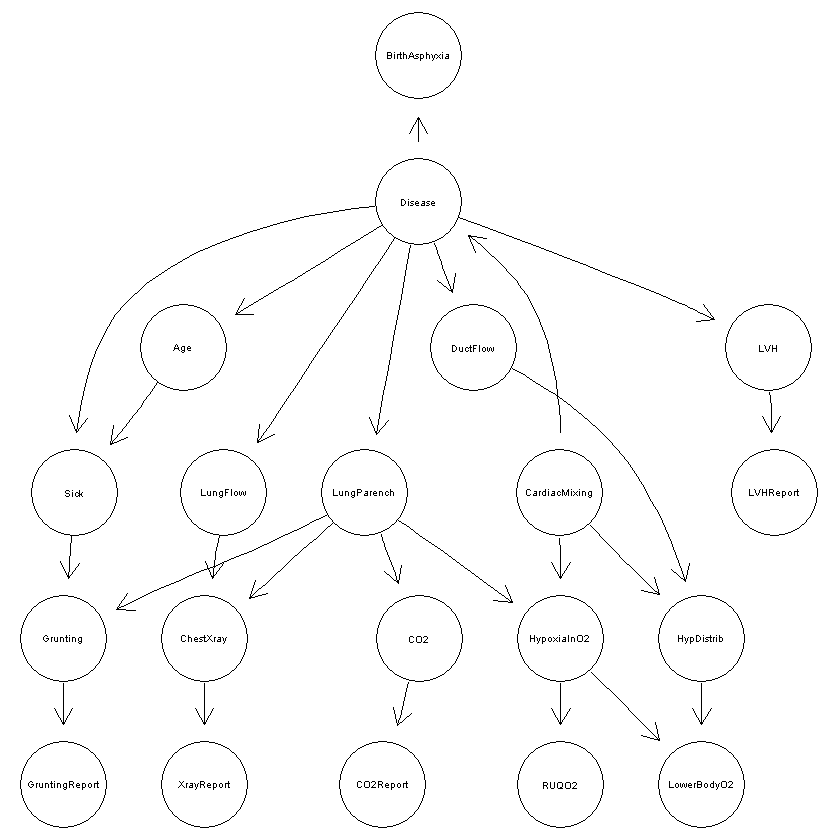

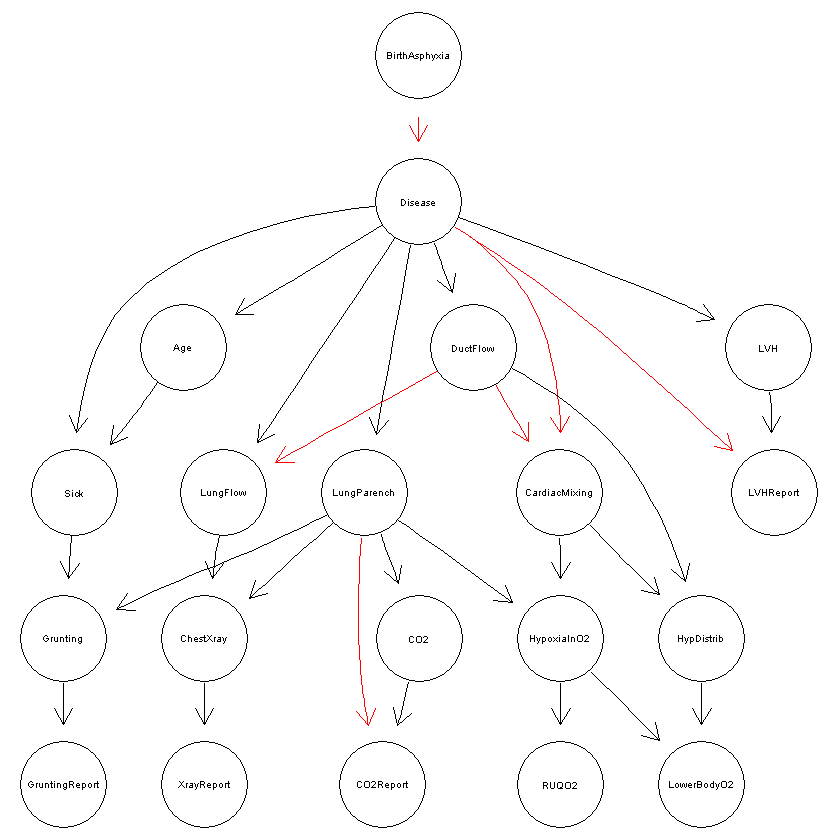

In [ ]:
graphviz.compare(child.imputed.bnstruct.dag, child.sann.dag, shape="circle")